<a href="https://colab.research.google.com/github/Keshav1506/Topic-Modelling-on-BBC-News-Articles-using-LDA/blob/main/Topic_Modelling_on_BBC_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modelling on BBC News Articles**
***
[BBC](https://www.bbc.com/) stands for British Broadcasting Corporation.

It is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world. The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.

The service maintains 50 foreign news bureaus with more than 250 correspondents around the world.

BBC News Online is the BBC's news website. It is one of the most popular news websites in the UK, reaching over a quarter of the UK's internet users, and worldwide, with around 14 million global readers every month. 

The website contains international news coverage as well as articles based on entertainment, sport, science, and political news.



## **Objective** 

In this project the task is to identify major themes/topics across a collection of BBC news articles. 

## **Importing Neccessary Modules**

Now in this section we'll import all the neccessary libraries and packages we'll require to develop the required model.

In [1]:
# importing os module
import os

# importing CountVectorizer for feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# Importing data manipulation libraries
import numpy as np
import pandas as pd

# importing tqdm and display modules for progress meters/bars
from IPython.display import display
from tqdm import tqdm


# Importing Counter
from collections import Counter

# import ast(abstract syntax tree)
import ast

# importing data visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# importing mlab for implementing MATLAB functions
import matplotlib.mlab as mlab

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

# importing statistics module
import scipy.stats as stats

# importing TSNE for data exploration and visualizing high-dimensional data
from sklearn.manifold import TSNE

# importing decomposition modules
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

## **Data Gathering and Discovery**

Now we'll gather the data files and perform some basic operations to understand the data and how we can process it to improve the model performance.

In [2]:
# Mounting the Google Drive to access data.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Note:-** The dataset in this case isn't collective, its been stored in form of numerous text files sub-categorized in 5 different domains. Hence, for loading the data we'll visit all text files individually and copy all articles to a dataframe along with their category.

In [ ]:
# The variable "directory" holds the address of text files stored in drive
directory = '/content/drive/MyDrive/Colab Notebooks/Almabetter/Capstone Projects/Capstone Project 4 - Topic Modeling on BBC News Articles/bbc/'

# All 5 sub-categories provided
subdirs = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Create dataframe for gathering the articles
bbc = pd.DataFrame()
 
# Iterate over sub-directories to access the text files
for subdir in subdirs:

  # address to the subdirectory
  dir = directory + '/' + subdir

  # Iterate over all the text files present in a sub-directory
  for filename in os.listdir(dir):
    
    # Get file address
    filepath = os.path.join(dir, filename)

    # Traversing over text files and storing the articles into the dataframe
    try:
      data = open(filepath,'r').read()

      # escape characters to be ignored in the text
      escape = ['\n']
      
      # removing escape characters from text
      for elem in escape:
        data = data.replace(elem,' ')
      
      # Storing article to the dataframe
      dict1 = {'Filename': filename.split('.')[0], 'Contents': data.lower(), 'Category':subdir}
      bbc = bbc.append(dict1,ignore_index=True, verify_integrity=True)

    # Ignore exception, if any
    except:
      pass    

**The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology.**
There are over 2000 news article available in these categories.

In [ ]:
bbc

In [ ]:
# Dropping duplicate entries
bbc=bbc.drop_duplicates(subset=['Contents'], keep='first')

In [ ]:
bbc.shape


(2125, 3)

In [ ]:
reindexed_data = bbc.reset_index()
reindexed_data = reindexed_data["Contents"]

In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_content = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_content, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_content.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stpwrd = nltk.corpus.stopwords.words('english')


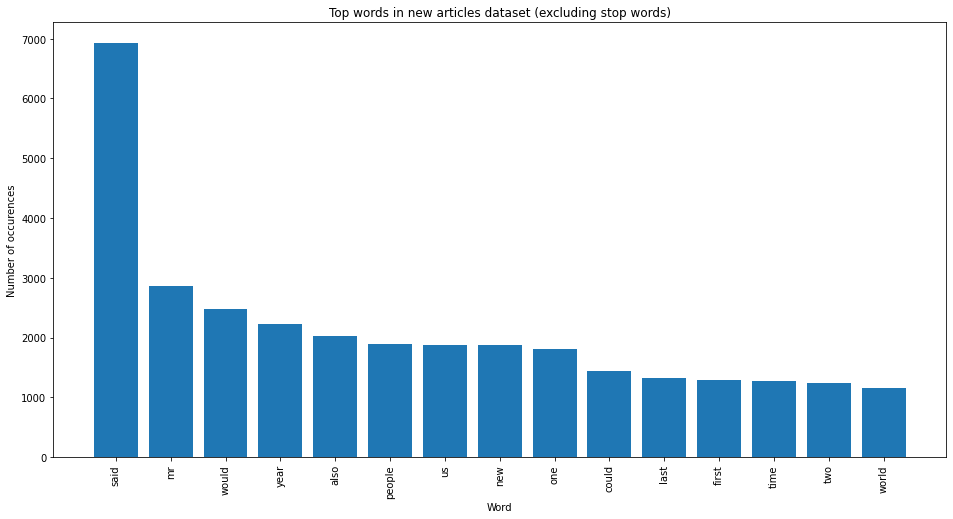

In [ ]:
count_vectorizer = CountVectorizer(stop_words=stpwrd)
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in new articles dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

Experiment (Stemming/Lemmatizing the data)

In [ ]:
reindexed_data

0       court rejects $280bn tobacco case  a us govern...
1       yukos loses us bankruptcy battle  a judge has ...
2       telegraph newspapers axe 90 jobs  the daily an...
3       india calls for fair trade rules  india, which...
4       ask jeeves tips online ad revival  ask jeeves ...
                              ...                        
2120    mobile tv tipped as one to watch  scandinavian...
2121    court mulls file-sharing future  judges at the...
2122    ultra fast wi-fi nears completion  ultra high ...
2123    looks and music to drive mobiles  mobile phone...
2124    gizmondo gadget hits the shelves  the gizmondo...
Name: Contents, Length: 2125, dtype: object

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download(['wordnet','omw-1.4'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:

for rows in reindexed_data:
 print(rows)
 test = [lemmatizer.lemmatize(words) for words in rows.split(' ')]
 print(test)
 break

court rejects $280bn tobacco case  a us government claim accusing the country's biggest tobacco companies of covering up the effects of smoking has been thrown out by an appeal court.  the demand for $280bn (£155bn) - filed by the clinton administration in 1999 - was rejected in a 2-1 decision. the court in washington found that the case could not be brought under federal anti-racketeering laws. among the accused were altria group, rj reynolds tobacco, lorillard tobacco, liggett group and brown and williamson. in its case, the government claimed tobacco firms manipulated nicotine levels to increase addiction, targeted teenagers with multi-billion dollar advertising campaigns, lied about the dangers of smoking and ignored research to the contrary.  prosecutors wanted the cigarette firms to surrender $280bn in profits accumulated over the past 50 years and impose tougher rules on marketing their products. but the court of appeals for the district of columbia ruled that the us government 

In [ ]:
sno = nltk.stem.SnowballStemmer('english')

In [ ]:
for rows in reindexed_data:
 print(rows)
 test = [sno.stem(words) for words in rows.split(' ')]
 print(test)
 break

court rejects $280bn tobacco case  a us government claim accusing the country's biggest tobacco companies of covering up the effects of smoking has been thrown out by an appeal court.  the demand for $280bn (£155bn) - filed by the clinton administration in 1999 - was rejected in a 2-1 decision. the court in washington found that the case could not be brought under federal anti-racketeering laws. among the accused were altria group, rj reynolds tobacco, lorillard tobacco, liggett group and brown and williamson. in its case, the government claimed tobacco firms manipulated nicotine levels to increase addiction, targeted teenagers with multi-billion dollar advertising campaigns, lied about the dangers of smoking and ignored research to the contrary.  prosecutors wanted the cigarette firms to surrender $280bn in profits accumulated over the past 50 years and impose tougher rules on marketing their products. but the court of appeals for the district of columbia ruled that the us government 

In [ ]:
from textblob import TextBlob, Word

In [ ]:
for rows in reindexed_data:
 print(rows)
 test = [Word(words).lemmatize() for words in rows.split(' ')]
 print(test)
 break

court rejects $280bn tobacco case  a us government claim accusing the country's biggest tobacco companies of covering up the effects of smoking has been thrown out by an appeal court.  the demand for $280bn (£155bn) - filed by the clinton administration in 1999 - was rejected in a 2-1 decision. the court in washington found that the case could not be brought under federal anti-racketeering laws. among the accused were altria group, rj reynolds tobacco, lorillard tobacco, liggett group and brown and williamson. in its case, the government claimed tobacco firms manipulated nicotine levels to increase addiction, targeted teenagers with multi-billion dollar advertising campaigns, lied about the dangers of smoking and ignored research to the contrary.  prosecutors wanted the cigarette firms to surrender $280bn in profits accumulated over the past 50 years and impose tougher rules on marketing their products. but the court of appeals for the district of columbia ruled that the us government 

end

In [ ]:
count_vectorizer = CountVectorizer(stop_words=stpwrd, max_features=4000)
text_sample = reindexed_data

print('Content before vectorization: {}'.format(text_sample[123]))

document_term_matrix = count_vectorizer.fit_transform(text_sample)

print('Content after vectorization: \n{}'.format(document_term_matrix[123]))

Content before vectorization: uk 'risks breaking golden rule'  the uk government will have to raise taxes or rein in spending if it wants to avoid breaking its "golden rule", a report suggests.  the rule states that the government can borrow cash only to invest, and not to finance its spending projects. the national institute of economic and social research (niesr) claims that taxes need to rise by about £10bn if state finances are to be put in order. the treasury said its plans were on track and funded until 2008. according to niesr, if the government's current economic cycle runs until march 2006 then it is "unlikely" the golden rule will be met. should the cycle end a year earlier, then the chances improve to "50/50". either way, fiscal tightening is needed, niesr said.  the report is the latest to call into question the viability of government spending projections. earlier this month, accountancy firm ernst & young said that chancellor of the exchequer gordon brown's forecasts for 

In [ ]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : [5]}

# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda, param_grid = grid_params)
lda_model.fit(document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -643494.9704171557
LDA model Perplexity on train data 1696.6352006244963


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=9fbcbc75812276ed8913bf4fce85299624750be07750efb7235c06eafe9abb5e
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, document_term_matrix,count_vectorizer,mds='tsne')
lda_panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  31.561681
1       51.163364 -159.968018       2        1  25.582728
4      -73.144554   21.523815       3        1  19.669203
3      -66.410133 -110.606438       4        1  11.874498
0       54.417324   12.443444       5        1  11.311890, topic_info=         Term         Freq        Total Category  logprob  loglift
1453     film   830.000000   830.000000  Default  30.0000  30.0000
482      best   924.000000   924.000000  Default  29.0000  29.0000
3986     year  2199.000000  2199.000000  Default  28.0000  28.0000
1570     game   848.000000   848.000000  Default  27.0000  27.0000
2377       mr  2827.000000  2827.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
447       bbc   155.387228   732.387788   Topic5  -5.6277   0.6289
2067     last   153.623804  1318.777302   Topic5  -5.6391   0.0294
568   british   141.516991   525.563533   Topic5  -5.7212   0.8673
3649     time   145.779972  1270.431281   Topic5  -5.6915   0.0143
2195     made   133.083236   820.697505   Topic5  -5.7826   0.3601

[416 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.245240      000
0         2  0.514602      000
0         3  0.033503      000
0         4  0.120610      000
0         5  0.087107      000
...     ...       ...      ...
3987      3  0.269165    years
3987      4  0.148145    years
3987      5  0.132496    years
3995      5  0.993515  yugansk
3997      5  0.995289    yukos

[903 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 4, 1])

In [ ]:
#creating docterms df
docterms = lda_panel.token_table.sort_values(by=['Freq'],ascending=False)


In [ ]:
docterms

,Topic,Freq,Term
term,,,
572,1,0.998099,broadband
3791,1,0.997966,users
1536,2,0.997078,fraud
162,5,0.996882,actress
2643,1,0.996657,phones
...,...,...,...
1570,2,0.002358,game
3788,4,0.002018,used
3588,3,0.001994,technology


In [ ]:
#Creating Dataframe to contain top 50 terms by topic
topicsdf=pd.DataFrame()

In [ ]:
for i in range(1,6):
  Topicdict ={ "Topic":i, "Terms":list(docterms[docterms['Topic']==i]['Term'].head(50))  }
  topicsdf=topicsdf.append(Topicdict,ignore_index=True)


Topic 1 wordcloud

In [ ]:
#creating term freq dict for t1
t1dict = {}
for vals in docterms[docterms['Topic']==1].head(40).values:
  t1dict[vals[2]] =vals[1]
  

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1200, height = 700,
                background_color ='beige',
                min_font_size = 10).generate(' '.join(list(t1dict.keys())))
wordcloud = wordcloud.generate_from_frequencies(frequencies=t1dict)


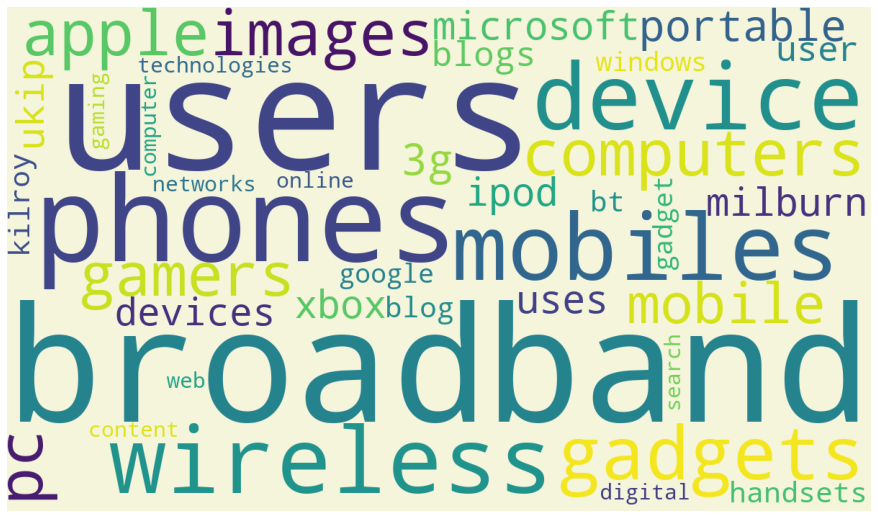

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (12,7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Topic 2 wordcloud



In [ ]:
#creating term freq dict for t2
t2dict = {}
for vals in docterms[docterms['Topic']==2].head(40).values:
  t2dict[vals[2]] =vals[1]
  

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1200, height = 700,
                background_color ='black',
                min_font_size = 10).generate(' '.join(list(t2dict.keys())))
wordcloud = wordcloud.generate_from_frequencies(frequencies=t2dict)


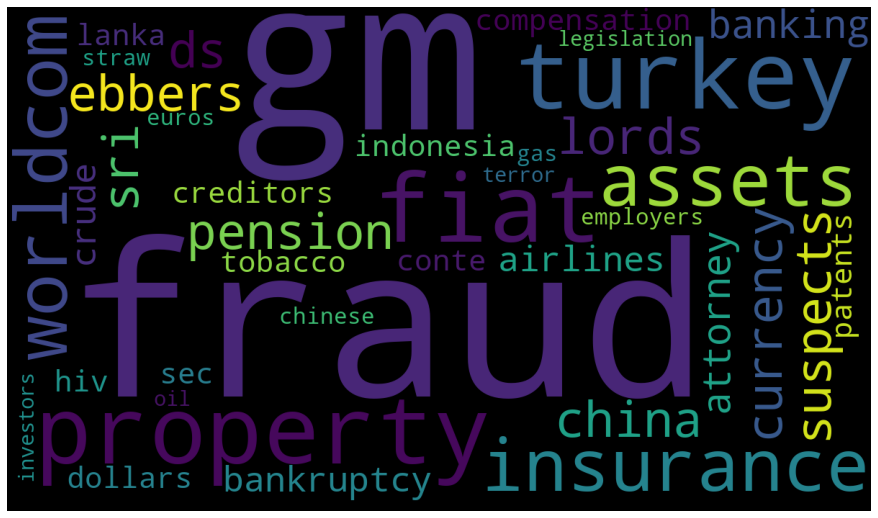

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (12,7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Topic 3 Wordcloud

In [ ]:
#creating term freq dict for t3
t3dict = {}
for vals in docterms[docterms['Topic']==3].head(40).values:
  t3dict[vals[2]] =vals[1]
  

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1200, height = 700,
                background_color ='magenta',
                min_font_size = 10).generate(' '.join(list(t3dict.keys())))
wordcloud = wordcloud.generate_from_frequencies(frequencies=t3dict)


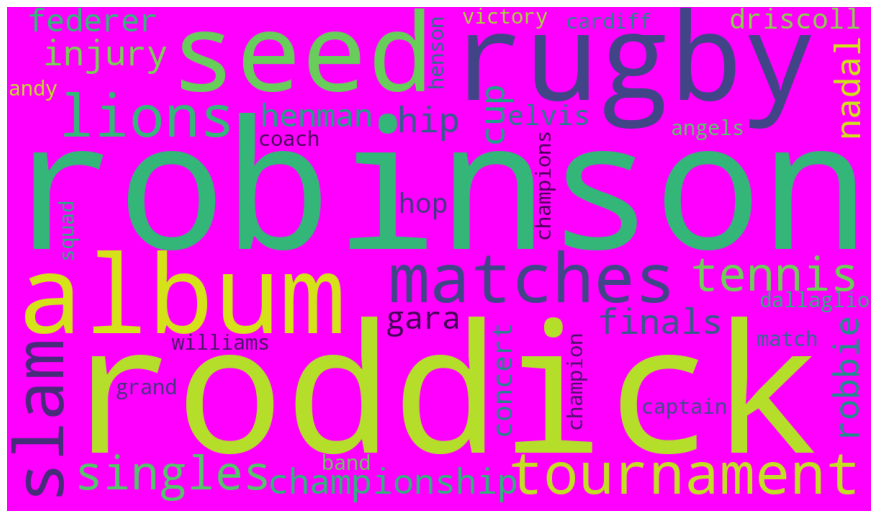

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (12,7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Topic 4 wordcloud

In [ ]:
#creating term freq dict for t4
t4dict = {}
for vals in docterms[docterms['Topic']==4].head(40).values:
  t4dict[vals[2]] =vals[1]
  

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1200, height = 700,
                background_color ='cyan',
                min_font_size = 10).generate(' '.join(list(t4dict.keys())))
wordcloud = wordcloud.generate_from_frequencies(frequencies=t4dict)


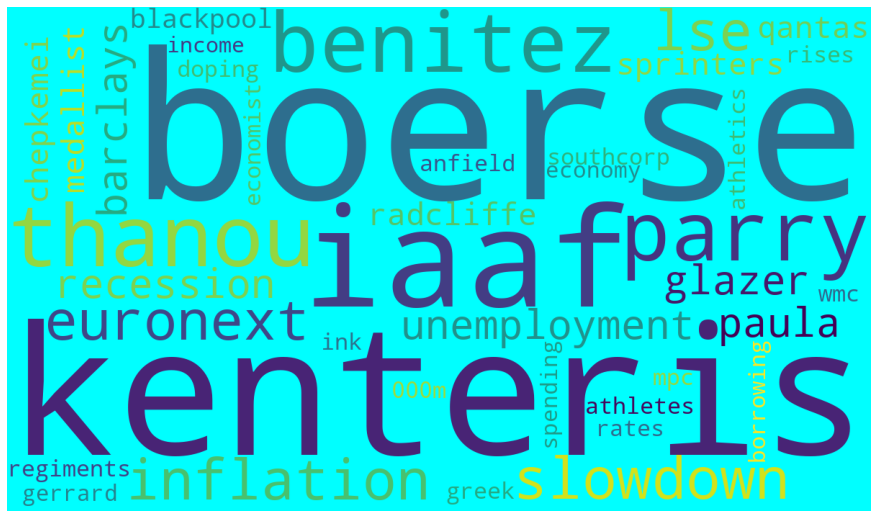

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (12,7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

topic 5 wordcloud

In [ ]:
#creating term freq dict for t3
t5dict = {}
for vals in docterms[docterms['Topic']==5].head(40).values:
  t5dict[vals[2]] =vals[1]
  

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1200, height = 700,
                background_color ='maroon',
                min_font_size = 10).generate(' '.join(list(t5dict.keys())))
wordcloud = wordcloud.generate_from_frequencies(frequencies=t5dict)


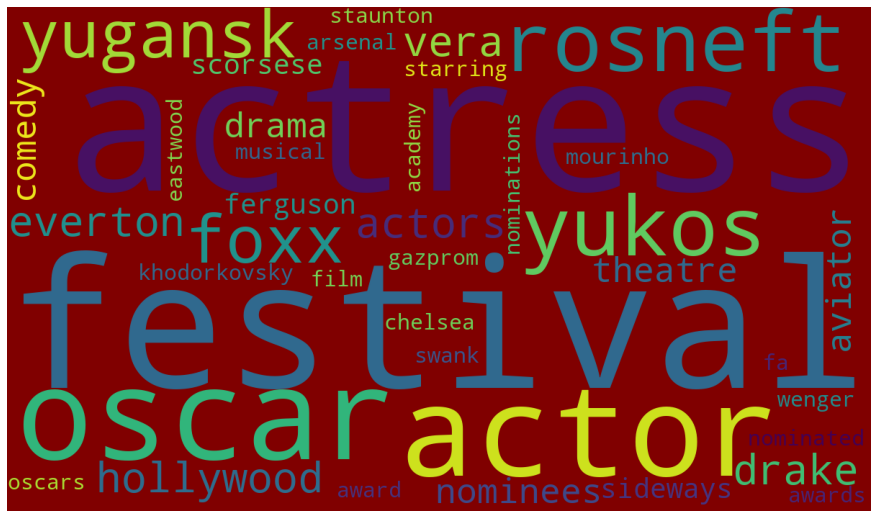

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (12,7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Conclusions (intuitive) (Keshav, Sahil, Jayesh kindly simplify anything which seems complex)

1. While reading the text files, we noticed that the file encoding was different in a few off-cases. We found that considering such factors, and engineering based on such knowledge, is very important while handling such data, in order to do so efficiently.

2. Upon experimenting with stemming and lemmatization on our dataset, we found that although it saves space and perhaps time, in our case, it's better to focus on quality, and avoid nuances. In our own 'cost-benefit' analysis, the difference weren't all that significant. Perhaps at a massive scale, the former approach would be ideal.

3. We noticed that it's more optimal to tokenize with no factual differences. 
so we lowercased the contents to unify tokens that may have just case-differences.

4. These are the optimal lda metrics that we got after implementing GridSearchCV: 

  Best LDA model's params {'n_components': 5}

  Best log likelihood Score for the LDA model -643494.9704171557

  LDA model Perplexity on train data 1696.6352006244963

5. Upon looking at the top n topics generated, we were able to correlate it with relevance to what was expected at a significant degree, whilst also shedding light on some unseen aspects.. Hence, we see that the model effectively beared fruit. 